In [1]:
import time
import numpy as np
import awkward as ak
from coffea import processor
import hist
import matplotlib.pyplot as plt

# The opendata files are non-standard NanoAOD, so some optional data columns are missing
processor.NanoAODSchema.warn_missing_crossrefs = False


def run(query, chunksize=1_000, workers=1):
    tic = time.monotonic()
    output, metrics = processor.run_uproot_job(
        fileset={"SingleMu": ["/ssd/Run2012B_SingleMu.root"]},
        treename="Events",
        processor_instance=query(),
        executor=processor.futures_executor,
        executor_args={
            "workers": workers,
            "schema": processor.NanoAODSchema,
            "savemetrics": True,
            "status": False,
        },
        chunksize=chunksize,
        maxchunks=1,
    )
    toc = time.monotonic()
    metrics["query"] = query.__name__
    metrics["chunksize"] = chunksize
    metrics["workers"] = workers
    metrics["walltime"] = toc - tic
    return output, metrics

# Query 1

Plot the <i>E</i><sub>T</sub><sup>miss</sup> of all events.

{'columns': {'MET_pt'},
 'entries': 53446198,
 'processtime': 4.17014479637146,
 'bytesread': 320582725,
 'chunks': 107,
 'query': 'Q1Processor',
 'walltime': 0.8897299460004433}

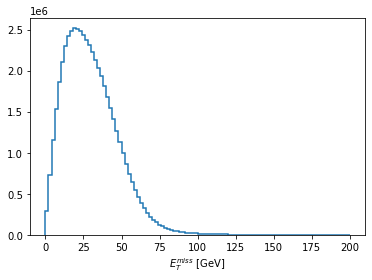

In [78]:
class Q1Processor(processor.ProcessorABC):
    def process(self, events):
        return (
            hist.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
            .Double()
            .fill(events.MET.pt)
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q1Processor)
out.plot1d()
metrics

# Query 2
Plot the <i>p</i><sub>T</sub> of all jets.

{'columns': {'Jet_pt', 'nJet'},
 'entries': 53446198,
 'processtime': 15.621905326843262,
 'bytesread': 900594136,
 'chunks': 107,
 'query': 'Q2Processor',
 'walltime': 1.3686401100021612}

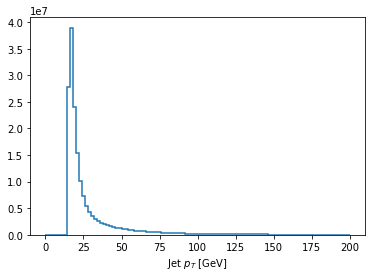

In [79]:
class Q2Processor(processor.ProcessorABC):
    def process(self, events):
        return (
            hist.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
            .Double()
            .fill(ak.flatten(events.Jet.pt))
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q2Processor)
out.plot1d()
metrics

# Query 3
Plot the <i>p</i><sub>T</sub> of jets with |<i>η</i>| < 1.

{'columns': {'Jet_eta', 'Jet_pt', 'nJet'},
 'entries': 53446198,
 'processtime': 27.906603574752808,
 'bytesread': 1689254019,
 'chunks': 107,
 'query': 'Q3Processor',
 'walltime': 1.4977716690009402}

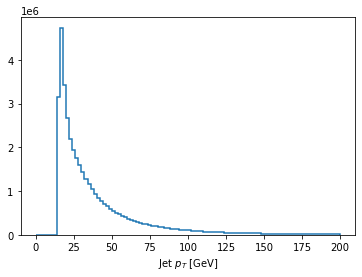

In [80]:
class Q3Processor(processor.ProcessorABC):
    def process(self, events):
        return (
            hist.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
            .Double()
            .fill(ak.flatten(events.Jet[abs(events.Jet.eta) < 1].pt))
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q3Processor)
out.plot1d()
metrics

# Query 4
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have at least two jets with <i>p</i><sub>T</sub> > 40 GeV.

{'columns': {'Jet_pt', 'MET_pt', 'nJet'},
 'entries': 53446198,
 'processtime': 18.958741903305054,
 'bytesread': 1130015108,
 'chunks': 107,
 'query': 'Q4Processor',
 'walltime': 3.489924968998821}

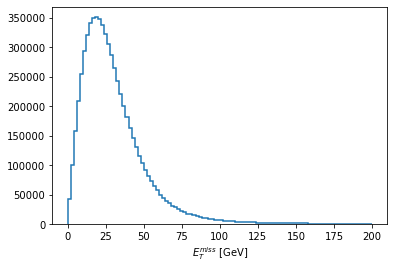

In [81]:
class Q4Processor(processor.ProcessorABC):
    def process(self, events):
        has2jets = ak.sum(events.Jet.pt > 40, axis=1) >= 2
        return (
            hist.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
            .Double()
            .fill(events[has2jets].MET.pt)
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q4Processor)
out.plot1d()
metrics

# Query 5
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have an
opposite-charge muon pair with an invariant mass between 60 and 120 GeV.

{'columns': {'MET_pt',
  'Muon_charge',
  'Muon_eta',
  'Muon_mass',
  'Muon_phi',
  'Muon_pt',
  'nMuon'},
 'entries': 53446198,
 'processtime': 66.5076630115509,
 'bytesread': 1701024895,
 'chunks': 107,
 'query': 'Q5Processor',
 'walltime': 2.8083927089974168}

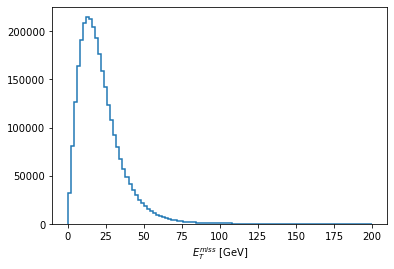

In [82]:
class Q5Processor(processor.ProcessorABC):
    def process(self, events):
        mupair = ak.combinations(events.Muon, 2)
        with np.errstate(invalid="ignore"):
            pairmass = (mupair.slot0 + mupair.slot1).mass
        goodevent = ak.any(
            (pairmass > 60)
            & (pairmass < 120)
            & (mupair.slot0.charge == -mupair.slot1.charge),
            axis=1,
        )
        return (
            hist.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
            .Double()
            .fill(events[goodevent].MET.pt)
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q5Processor)
out.plot1d()
metrics

# Query 6
For events with at least three jets, plot the <i>p</i><sub>T</sub> of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum <i>b</i>-tagging discriminant value among the jets in this trijet.

{'columns': {'Jet_btag', 'Jet_eta', 'Jet_mass', 'Jet_phi', 'Jet_pt', 'nJet'},
 'entries': 53446198,
 'processtime': 2319.1790437698364,
 'bytesread': 3683466832,
 'chunks': 107,
 'query': 'Q6Processor',
 'walltime': 61.87590003999867}

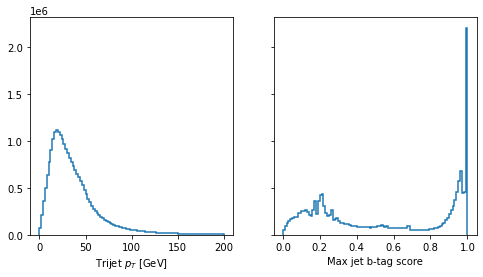

In [83]:
class Q6Processor(processor.ProcessorABC):
    def process(self, events):
        trijet = ak.combinations(events.Jet, 3, fields=["j1", "j2", "j3"])
        trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
        trijet = ak.flatten(
            trijet[ak.singletons(ak.argmin(abs(trijet.p4.mass - 172.5), axis=1))]
        )
        maxBtag = np.maximum(
            trijet.j1.btag,
            np.maximum(
                trijet.j2.btag,
                trijet.j3.btag,
            ),
        )
        return {
            "trijetpt": hist.Hist.new.Reg(
                100, 0, 200, name="pt3j", label="Trijet $p_{T}$ [GeV]"
            )
            .Double()
            .fill(trijet.p4.pt),
            "maxbtag": hist.Hist.new.Reg(
                100, 0, 1, name="btag", label="Max jet b-tag score"
            )
            .Double()
            .fill(maxBtag),
        }

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q6Processor)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
out["trijetpt"].plot1d(ax=ax1)
out["maxbtag"].plot1d(ax=ax2)
metrics

# Query 7
Plot the scalar sum in each event of the <i>p</i><sub>T</sub> of jets with <i>p</i><sub>T</sub> > 30 GeV that are not within 0.4 in Δ<i>R</i> of any light lepton with <i>p</i><sub>T</sub> > 10 GeV.

{'columns': {'Electron_eta',
  'Electron_phi',
  'Electron_pt',
  'Jet_eta',
  'Jet_phi',
  'Jet_pt',
  'Muon_eta',
  'Muon_phi',
  'Muon_pt',
  'nElectron',
  'nJet',
  'nMuon'},
 'entries': 53446198,
 'processtime': 145.54463362693787,
 'bytesread': 3915072560,
 'chunks': 107,
 'query': 'Q7Processor',
 'walltime': 5.13990437800021}

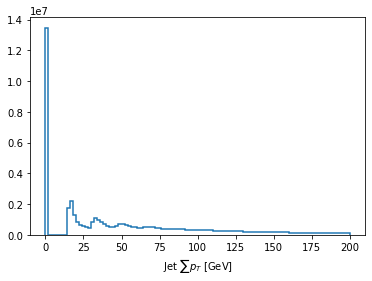

In [84]:
class Q7Processor(processor.ProcessorABC):
    def process(self, events):
        cleanjets = events.Jet[
            ak.all(
                events.Jet.metric_table(events.Muon[events.Muon.pt > 10]) >= 0.4, axis=2
            )
            & ak.all(
                events.Jet.metric_table(events.Electron[events.Electron.pt > 10]) >= 0.4,
                axis=2,
            )
            & (events.Jet.pt > 30)
        ]
        return (
            hist.Hist.new.Reg(
                100, 0, 200, name="sumjetpt", label="Jet $\sum p_{T}$ [GeV]"
            )
            .Double()
            .fill(ak.sum(cleanjets.pt, axis=1))
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q7Processor)
out.plot1d()
metrics

# Query 8
For events with at least three light leptons and a same-flavor opposite-charge light lepton pair, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing tranverse momentum and the highest-<i>p</i><sub>T</sub> light lepton not in this pair.

{'columns': {'Electron_charge',
  'Electron_eta',
  'Electron_mass',
  'Electron_phi',
  'Electron_pt',
  'MET_phi',
  'MET_pt',
  'Muon_charge',
  'Muon_eta',
  'Muon_mass',
  'Muon_phi',
  'Muon_pt',
  'nElectron',
  'nMuon'},
 'entries': 53446198,
 'processtime': 102.2785713672638,
 'bytesread': 2297983314,
 'chunks': 107,
 'query': 'Q8Processor',
 'walltime': 3.4811691399991105}

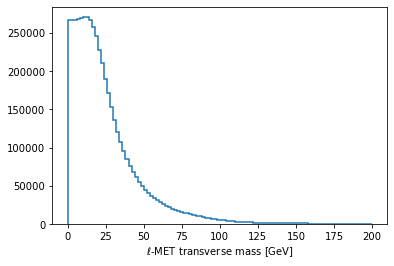

In [85]:
class Q8Processor(processor.ProcessorABC):
    def process(self, events):
        events["Electron", "pdgId"] = -11 * events.Electron.charge
        events["Muon", "pdgId"] = -13 * events.Muon.charge
        events["leptons"] = ak.concatenate(
            [events.Electron, events.Muon],
            axis=1,
        )
        events = events[ak.num(events.leptons) >= 3]

        pair = ak.argcombinations(events.leptons, 2, fields=["l1", "l2"])
        pair = pair[(events.leptons[pair.l1].pdgId == -events.leptons[pair.l2].pdgId)]
        with np.errstate(invalid="ignore"):
            pair = pair[
                ak.singletons(
                    ak.argmin(
                        abs(
                            (events.leptons[pair.l1] + events.leptons[pair.l2]).mass
                            - 91.2
                        ),
                        axis=1,
                    )
                )
            ]
        events = events[ak.num(pair) > 0]
        pair = pair[ak.num(pair) > 0][:, 0]

        l3 = ak.local_index(events.leptons)
        l3 = l3[(l3 != pair.l1) & (l3 != pair.l2)]
        l3 = l3[ak.argmax(events.leptons[l3].pt, axis=1, keepdims=True)]
        l3 = events.leptons[l3][:, 0]

        mt = np.sqrt(2 * l3.pt * events.MET.pt * (1 - np.cos(events.MET.delta_phi(l3))))
        return (
            hist.Hist.new.Reg(
                100, 0, 200, name="mt", label="$\ell$-MET transverse mass [GeV]"
            )
            .Double()
            .fill(mt)
        )

    def postprocess(self, accumulator):
        return accumulator


out, metrics = run(Q8Processor)
out.plot1d()
metrics

# Systematic benchmark

In [113]:
from itertools import product
import tqdm


queries = [
    Q1Processor,
    Q2Processor,
    Q3Processor,
    Q4Processor,
    Q5Processor,
    Q6Processor,
    Q7Processor,
    Q8Processor,
]
chunksizes = 2 ** np.arange(12, 21)
ncores = 2 ** np.arange(0, 5) * 3

In [114]:
results = []

In [116]:
benchpoints = list(product(queries, chunksizes, [48]))
for query, chunksize, workers in tqdm.tqdm(benchpoints):
    _, metrics = run(query, chunksize, workers)
    del metrics["columns"]
    results.append(metrics)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [32:41<00:00, 27.24s/it]


In [118]:
import pandas as pd
df = pd.DataFrame(results)

Text(0, 0.5, 'Total time in process() function')

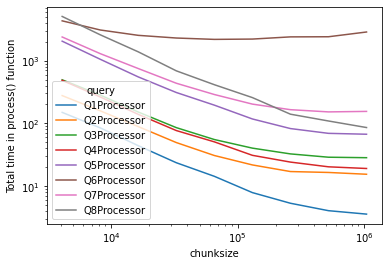

In [146]:
ax = df.set_index(["chunksize", "query"]).unstack().plot(y="processtime")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Total time in process() function")

Text(0, 0.5, 'Wall time')

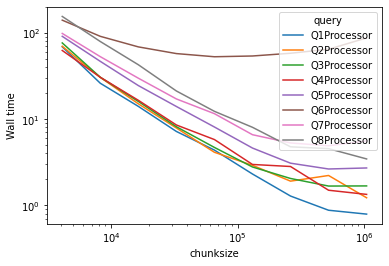

In [147]:
ax = df.set_index(["chunksize", "query"]).unstack().plot(y="walltime")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Wall time")

Text(0, 0.5, 'Bytes read from file')

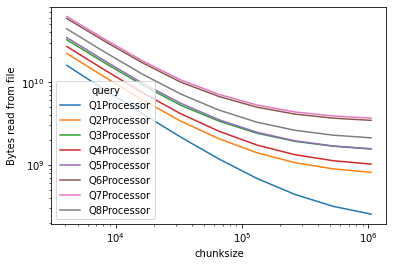

In [148]:
ax = df.set_index(["chunksize", "query"]).unstack().plot(y="bytesread")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Bytes read from file")

In [149]:
benchpoints = list(product(queries, [2**19], ncores))
for query, chunksize, workers in tqdm.tqdm(benchpoints):
    _, metrics = run(query, chunksize, workers)
    del metrics["columns"]
    results.append(metrics)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [19:19<00:00, 28.99s/it]


In [150]:
df = pd.DataFrame(results)

Text(0, 0.5, 'Wall time [s]')

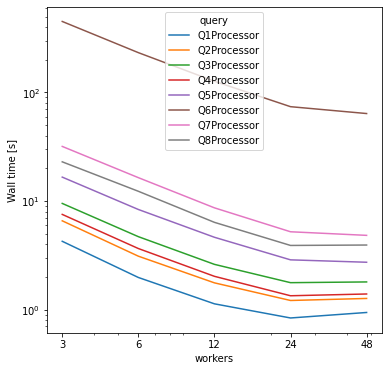

In [174]:
fig, ax = plt.subplots(figsize=(6,6))
x = df.iloc[72:].set_index(["workers", "query"]).unstack()
ax = x.walltime.plot(ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(ncores)
import matplotlib.ticker
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Wall time [s]")

In [162]:
x.walltime

query,Q1Processor,Q2Processor,Q3Processor,Q4Processor,Q5Processor,Q6Processor,Q7Processor,Q8Processor
workers,,,,,,,,
3,4.252847,6.569053,9.499004,7.524614,16.599118,451.078824,31.837917,22.959337
6,1.974499,3.101976,4.693490,3.648578,8.354993,232.807041,16.414057,12.292007
12,1.128797,1.761455,2.607634,2.023110,4.632509,126.889338,8.650834,6.358836
24,0.836094,1.211709,1.768316,1.339561,2.869700,73.977420,5.206586,3.895366
48,0.939503,1.265273,1.795972,1.390793,2.727209,63.954980,4.824485,3.929561
